In [11]:
import numpy as np
import cv2
from string import ascii_uppercase as letters

import matplotlib.pyplot as plt
%matplotlib inline
import cv2.aruco

In [12]:
def get_center(sq):
    return sq.mean(axis=0)

def sort_sides(sq):
    #Чтобы координаты квадрата были в определенном порядке
    sq = list(sq)
    sq.sort(key = lambda x: x[0] + x[1])
    if sq[1][1] < sq [2][1]:
        sq[1], sq[2] = sq[2], sq[1]
    return np.array(sq)

def sort_squares(sq):
    #Чтобы квадраты были в определенном порядке
    sq = list(sq)
    sq.sort(key = lambda x: x[0][0] + x[0][1])
    if sq[1][0][1] < sq [2][0][1]:
        sq[1], sq[2] = sq[2], sq[1]
    return sq

def get_letter(img, position, cell_size=90, cut=0):
    return img[position[1]+cut:position[1]+cell_size-cut, position[0]+cut:position[0]+cell_size-cut]

In [13]:
def multi_check(y, x, h, check_arr=(5, 10, 15), check_type="x", dst_type = 1, debug=False):
    counter = 0
    if debug:
        print(y, x)
        print(h)
        
    if check_type == "x":
        for val in check_arr:
            if h[y + val*dst_type, x]:
                counter += 1
                
    if check_type == "y":
        for val in check_arr:
            if h[y, x + val*dst_type]:
                counter += 1

    if debug: print (counter)
    return counter

In [14]:
def ultra_ultimate_adaptive_get_letter_y(img, position, cell_size=90, cut=0, check=4, border=1, adaptive=True, debug=False):
    f = get_letter(img, position, cut=cut)
    if not adaptive:
        return position
        #return f
    
    if debug:
        plt.imshow(f)
        plt.show()
        
    
    fg = cv2.cvtColor(f, cv2.COLOR_RGBA2GRAY)

    h = fg < 220
    #true-черный пиксель
    margin_top = 0
    margin_bottom = 0


    for i in range(check):
        if multi_check(h.shape[0] - i -1, 0, h, dst_type=1, debug=debug, check_type="y") + multi_check(h.shape[0] - i -1, -1, h, dst_type=-1, debug=debug, check_type="y") >= 3:
            margin_top = i + 1
            break
            
    for i in range(check):
        if multi_check(i, -1, h, dst_type=1, debug=debug, check_type="y") + multi_check(i, 0, h, dst_type=-1, debug=debug, check_type="y") >= 3:
            margin_bottom = i + 1
            break

            
            
    if debug:    
        print("\ntop {} \nbottom {}".format(margin_top, margin_bottom))
        margin_y = margin_top - margin_bottom
        plt.imshow(img[position[1]+cut:position[1]+cell_size-cut, position[0]+cut:position[0]+cell_size-cut - margin_y])
        plt.show()

        
    while multi_check(h.shape[0] - margin_top -1, 0, h, dst_type=1, debug=debug, check_type="y") + multi_check(h.shape[0] - margin_top -1, -1, h, dst_type=-1, debug=debug, check_type="y") >= 3:
        margin_top += 1

    while multi_check(margin_bottom, -1, h, dst_type=1, debug=debug, check_type="y") + multi_check(margin_bottom, 0, h, dst_type=-1, debug=debug, check_type="y") >= 3:
        margin_bottom += 1

    margin_y = margin_top - margin_bottom
    
    try:
        margin_y += (margin_y/abs(margin_y))*2
        margin_y = int(margin_y)
    except:
        pass

    if debug:
        print("\ntop {}\nbottom {}".format(margin_top, margin_bottom))
    
    return (position[0], position[1] - margin_y)

In [15]:
def ultra_ultimate_adaptive_get_letter_x(img, position, cell_size=90, cut=0, check=4, adaptive=True, debug=False):
    f = get_letter(img, position, cut=cut)
    
    if not adaptive:
        return position
        #return f
    
    if debug:
        plt.imshow(f)
        plt.show()
        

    fg = cv2.cvtColor(f, cv2.COLOR_RGBA2GRAY)

    h = fg < 220

    margin_left = 0
    margin_right = 0
    

    for i in range(check):
        if multi_check(0, h.shape[0] - i -1, h, dst_type=1, debug=debug) + multi_check(-1, h.shape[0] - i -1, h, dst_type=-1, debug=debug) >= 3:
            margin_left = i + 1
            break
            
    for i in range(check):
        if multi_check(-1, i, h, dst_type=1, debug=debug) + multi_check(0, i, h, dst_type=-1, debug=debug) >= 3:
            margin_right = i + 1
            break

            
            
    if debug:    
        print("\nleft {} \nright {}".format(margin_left, margin_right))
        margin_x = margin_left - margin_right
        plt.imshow(img[position[1]+cut:position[1]+cell_size-cut, position[0]+cut-margin_x:position[0]+cell_size-cut-margin_x])
        plt.show()

    while multi_check(0, h.shape[0] - margin_left -1, h, dst_type=1, debug=debug) + multi_check(-1, h.shape[0] - margin_left -1, h, dst_type=-1, debug=debug) >= 3:
        margin_left += 1

    while multi_check(-1, margin_right, h, dst_type=1, debug=debug) + multi_check(0, margin_right, h, dst_type=-1, debug=debug) >= 3:
        margin_right += 1

    margin_x = margin_left - margin_right
    
    try:
        margin_x += (margin_x/abs(margin_x))*2
        margin_x = int(margin_x)
    except:
        pass

    if debug:
        print("\nleft {}\nright {}".format(margin_left, margin_right))
    
    return (position[0]-margin_x, position[1])

In [6]:
import pickle

In [7]:
with open("positions.pickle", "rb") as f:
    positions = pickle.load(f)

In [9]:
#найдем, где мы хотим видеть центры
final_squares = []
final_squares.append([(40, 40), (110, 110)])
final_squares.append([(40, 3398), (110, 3468)])
final_squares.append([(2370, 40), (2440, 110)])
final_squares.append([(2370, 3398), (2440, 3468)])
final_squares = np.array(final_squares)
final_centers = list(map(get_center, final_squares))

coords_list1 = list(positions[0].keys())
coords_list2 = list(positions[1].keys())

In [26]:
def check_for_rubbish(letter):
    cnts = cv2.findContours((cv2.cvtColor(letter, cv2.COLOR_BGR2GRAY) < 180).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    lens = [cv2.arcLength(c, True) for c in cnts]
    app = [cv2.approxPolyDP(c, 0.02 * peri, True) for c, peri in zip(cnts, lens)]
    feat = sorted(list(zip(lens, app)), key=lambda x: x[0])
    if len(lens) > 1 and feat[-2][0] > 15 and len(feat[-2][1]) == 4:
        return False
    return True

In [27]:
import numpy as np
import cv2
from string import ascii_uppercase as letters
import os

import matplotlib.pyplot as plt
%matplotlib inline

scans = ["док{0}.jpg".format(i) for i in list(range(963,965)) + list(range(967,997))]

path_to_fold = '/Users/jana/letters'
os.makedirs(path_to_fold)
for scan in scans:
    image = cv2.imread(scan)
    #plt.figure(figsize=[35, 20])
    #plt.imshow(scan)

    total = 0
    edged = cv2.Canny(image, 20, 250)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    squares = []

    new_image = image.copy()
    for c in cnts:
    # аппроксимируем (сглаживаем) контур
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # если у контура 4 вершины, предполагаем, что это книга
        if len(approx) == 4:
            sides = []
            for i in range(len(approx)):
                sides.append(np.linalg.norm(approx[i]-approx[i-1]))
            if not (300 < sum(sides) < 490):   #исправить на часть листа размер
                continue
            #print(sides)
            squares.append(sort_sides(approx[:, 0, :]))
            cv2.drawContours(new_image, [approx], -1, (0, 255, 0), 10)
            total += 1
    #print("Я нашёл {0} квадратов на этой картинке".format(total))
    if total < 4:
        print(scan)
        continue
    squares = sort_squares(squares)

#найдем центры квадратов на скане
    centers = list(map(get_center, squares))

# В теории нужно первое, а второе излишне
#первый вариант
    rows,cols, ch = image.shape

    pts1 = np.array(centers[:3], dtype=np.float32)
    pts2 = np.array(final_centers[:3], dtype=np.float32)

    M = cv2.getAffineTransform(pts1 ,pts2)

    a4_size = (2481, 3507)

    dst = cv2.warpAffine(image,M,a4_size, flags=cv2.INTER_LANCZOS4)

    Dictionary = cv2.aruco.getPredefinedDictionary( cv2.aruco.DICT_5X5_250 )
    parameters =  cv2.aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(dst, Dictionary, parameters=parameters)
    #dst = cv2.aruco.drawDetectedMarkers(dst, corners)
    
    if ids[0][0] != 0 and ids[0][0] != 1:
        ids[0][0], ids[1][0] = ids[1][0], ids[0][0]
    quantity_of_letters = dict.fromkeys(letters, 0)
    newpath = '/Users/jana/letters/person{0}'.format(ids[1][0])
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if ids[0][0] == 0:
        for i in range(len(coords_list1)):
            quantity_of_letters[positions[ids[0][0]][coords_list1[i]]] += 1
            newpath_let = '/Users/jana/letters/person{0}/{1}'.format(ids[1][0], positions[ids[0][0]][coords_list1[i]])
            if not os.path.exists(newpath_let):
                os.makedirs(newpath_let)
            pos = ultra_ultimate_adaptive_get_letter_x(dst, coords_list1[i], cut=6, check=10, adaptive=1, debug=0)
            pos = ultra_ultimate_adaptive_get_letter_y(dst, pos, cut=6, check=5, adaptive=1, debug=0)
            letter = get_letter(dst, pos, cut=6)
            if check_for_rubbish(letter):
                cv2.imwrite(os.path.join(newpath_let , '{}.jpg'.format(quantity_of_letters[positions[ids[0][0]][coords_list1[i]]])), letter)
    else:
        for i in range(len(coords_list2)):
            max_name = 1
            newpath_let = '/Users/jana/letters/person{0}/{1}'.format(ids[1][0], positions[ids[0][0]][coords_list2[i]])
            if not os.path.exists(newpath_let):
                os.makedirs(newpath_let)
            else :
                files_list = os.listdir(newpath_let)
                files_list = [i.replace(".jpeg", ""). replace(".jpg", "") for i in files_list]
                files_list = list(map(int, files_list))
                if len(files_list) !=0 :
                    max_name = max(files_list) + 1
            pos = ultra_ultimate_adaptive_get_letter_x(dst, coords_list2[i], cut=6, check=10, adaptive=1, debug=0)
            pos = ultra_ultimate_adaptive_get_letter_y(dst, pos, cut=6, check=5, adaptive=1, debug=0)
            letter = get_letter(dst, pos, cut=6)
            if check_for_rubbish(letter):
                cv2.imwrite(os.path.join(newpath_let , '{}.jpg'.format(max_name)), letter)
    cv2.imwrite(os.path.join(newpath, scan), image)

док973.jpg
док991.jpg
док996.jpg


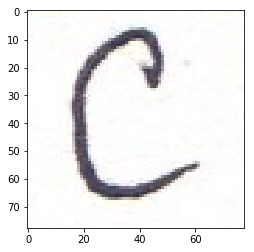

77 0
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
0
77 -1
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
0
76 0
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
0
76 -1
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [F

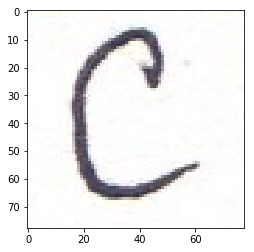

77 0
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
0
77 -1
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
0
0 -1
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
0
0 0
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [Fal

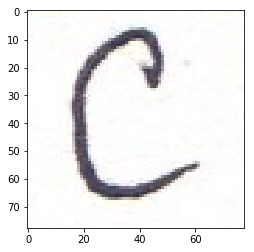

In [30]:
pos = ultra_ultimate_adaptive_get_letter_x(dst, coords_list1[14], cut=6, check=7, adaptive=1, debug=0)
pos = ultra_ultimate_adaptive_get_letter_y(dst, pos, cut=6, check=2, adaptive=1, debug=1)
plt.imshow(get_letter(dst, pos, cut=6))


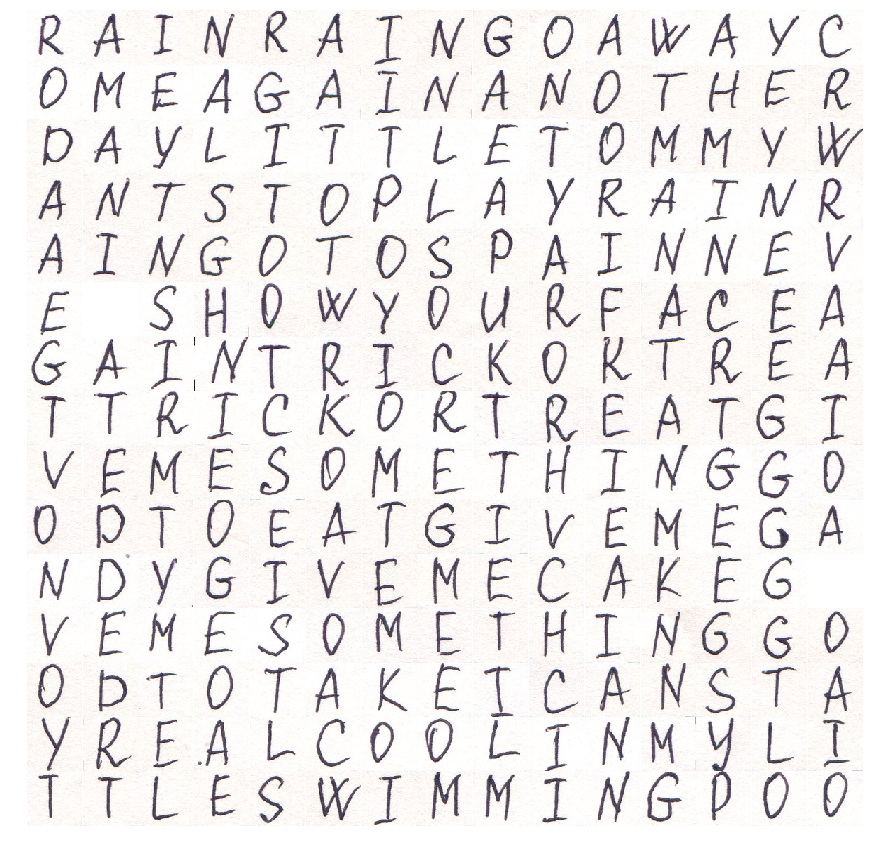

In [35]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

cnt = 15

plt.figure(figsize = (cnt,cnt))
gs1 = gridspec.GridSpec(cnt, cnt)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

for i in range(cnt**2):
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ad = 1
    pos = ultra_ultimate_adaptive_get_letter_x(dst, coords_list1[i], cut=6, check=12, adaptive=ad, debug=0)
    pos = ultra_ultimate_adaptive_get_letter_y(dst, pos, cut=6, check=5, adaptive=ad, debug=0)
    letter = get_letter(dst, pos, cut=6)
    cnts = cv2.findContours((cv2.cvtColor(letter, cv2.COLOR_BGR2GRAY) < 180).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    lens = [cv2.arcLength(c, True) for c in cnts]
    app = [cv2.approxPolyDP(c, 0.02 * peri, True) for c, peri in zip(cnts, lens)]
    feat = sorted(list(zip(lens, app)), key=lambda x: x[0])
    #print(feat)
    #print(lens)
    if len(lens) > 1 and feat[-2][0] > 15 and len(feat[-2][1]) == 4:
        continue
    plt.imshow(letter)
    ax1.set_aspect('equal')
    
#plt.savefig("nodelyes.png", dpi=300, bbox_inches='tight')
plt.show()